<a href="https://colab.research.google.com/github/Romario76/Pos-PUCRJ-Data-Science-Analytics/blob/SPRINT_ML-Analytics/MVP_Machine_Learning_(4052025000761).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Template — MVP: *Machine Learning & Analytics*
Nome: Romário Silva de Almeida

Matrícula: 4052025000761

Dataset: [Análise Lubrificantes Máquinas Móveis](https://github.com/Romario76/Pos-PUCRJ-Data-Science-Analytics/raw/refs/heads/SPRINT_ML-Analytics/Analise_lub_tratado.xlsx)

---
OBS:

Link para o notebook do MVP de Análise de Dados e Boas Práticas, que contém a análise exploratória e os tratamentos realizados, em detalhes.

Na etapa de AED deste notebook, foram inseridos os insights e os gráficos como texto/figuras para entendimento dos dados.

Já na etapa de limpeza e tratamento, as ações realizadas foram apenas descritas.

[MVP Análise de Dados e Boas Práticas](https://github.com/Romario76/Pos-PUCRJ-Data-Science-Analytics/blob/SPRINT_ADBP/MVP_An%C3%A1lise_de_Dados_e_Boas_Pr%C3%A1ticas_(4052025000761).ipynb)

---


# 1) Escopo, objetivo e definição do problema
Este é um problema de classificação supervisionada, através de dados tabulados.

O conjunto de dados contém resultados reais de testes em fluidos aplicados em máquinas de grande porte utilizadas nos processos de movimentação e extração de materiais em áreas de mineração.

O objetivo principal é classificar o estado geral de uma amostra, enquadrando-a nas classes pré-definidas: Normal, Alerta, Crítico.

A correta classificação é importante para detectar, preventivamente, alguma anomalia nos componentes dos equipamentos, permitindo uma intervenção antes de uma possível falha em campo. Com isso, reduzindo tempo e custos de manutenção e de indisponibilidade do equipamento.

*Informações de privacidade e sensibilidade dos dados:*

O dataset não possui informações sensíveis e nem fere nenhuma norma de privacidade. Contudo não é um dataset público, que se encontra hospedado em sites de livre acesso, como o Kaggle.

### 1.1) Hipóteses do Problema
As hipóteses levantadas são:

O estado da amostra está relacionada ao tempo de utilização (horas)?

O local/componente de aplicação influencia no resultado?

Qual a influência do site de operação do equipamento na análise?

Existe correlação entre o fabricante do lubrificante e o resultado da análise?


# 2) Reprodutibilidade e ambiente

O projeto foi desenvolvido no ambiente do Google Colab, plataforma que possui as principais bibliotecas que suportam a criação/manutenção de modelos de Machine Learning. Sua integração com o Github facilita o compartilhamento do trabalho, tanto no momento de salvar, quanto na hora de executar no Colab. A versão do Python utilizada é 3.12.11 (release: 03/06/2025).

A bibliotecas utilizadas foram Numpy e Pandas (manipulação e análise de dados), Seaborn, Matplotlib (gráficos), Scikit-learn (pré-processamento, modelagem e avaliação), Imblearn (pré-processamento) e outras auxiliares.

Para garantir maior reprodutibilidade, foi utilizado estruturas Pipeline, que evita vazamentos de dados e mantém a consistência nas execução de pré-processamento e treino.

A definição de uma Seed global garante que qualquer operação aleatória produza os mesmos resultados em todas as execuções.

In [1]:
#Importação das bibliotecas básicas
import os, random, time, sys, math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Importação para pré-processamento e preparação de dados
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold, RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from imblearn.under_sampling import RandomUnderSampler

#Importação para treinamento
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import (f1_score, recall_score,
                             balanced_accuracy_score)
#Importação para salvar e recuperar modelo treinado para otimizar o tempo de avaliação do MVP
import joblib

#Definição da reprodutibilidade
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print("Python:", sys.version.split()[0])
print("Seed global:", SEED)

Python: 3.12.11
Seed global: 42


### 2.2) Funções python

Definida uma função para avaliação dos modelos, que melhora a legibilidade e garante que qualquer alteração seja replicada ao longo código (inclusão/exclusão de métricas, alteração de parâmetros, etc)

In [2]:
#funçõo para avaliação dos modelos com as métricas mais apropriadas para o problema
def evaluate_classification(y_true, y_pred):
    bacc = balanced_accuracy_score(y_true, y_pred)
    f1w = f1_score(y_true, y_pred, average="weighted")
    recw = recall_score(y_true, y_pred, average="weighted")
    return {"accuracy": round(bacc,3), "f1_weighted": round(f1w,3), "recall_weighted": round(recw,3), "média": round((bacc+f1w+recw)/3,3)}



# 3) Dados: carga, entendimento e qualidade

O dataset é extraído de sistema de análise laboratorial de óleos lubrificantes, alimentado pelos instrumentos de medição dos laboratórios. Alguns dados são inputados manualmente e outros são inseridos eletrônicamente no banco de dados, através de um sistema proprietário, ligado aos instrumentos.

Por conter dados que são inseridos manualmente, a qualidade do dataset é impactada, por exemplo, com valores vazios, falta de padronização para alguma informações e reaproveitamento de campos para outras finalidades.

### 3.1) Atributos do Dataset
Originalmente, o dataset contém 35.601 amostras e 131 **atributos**:


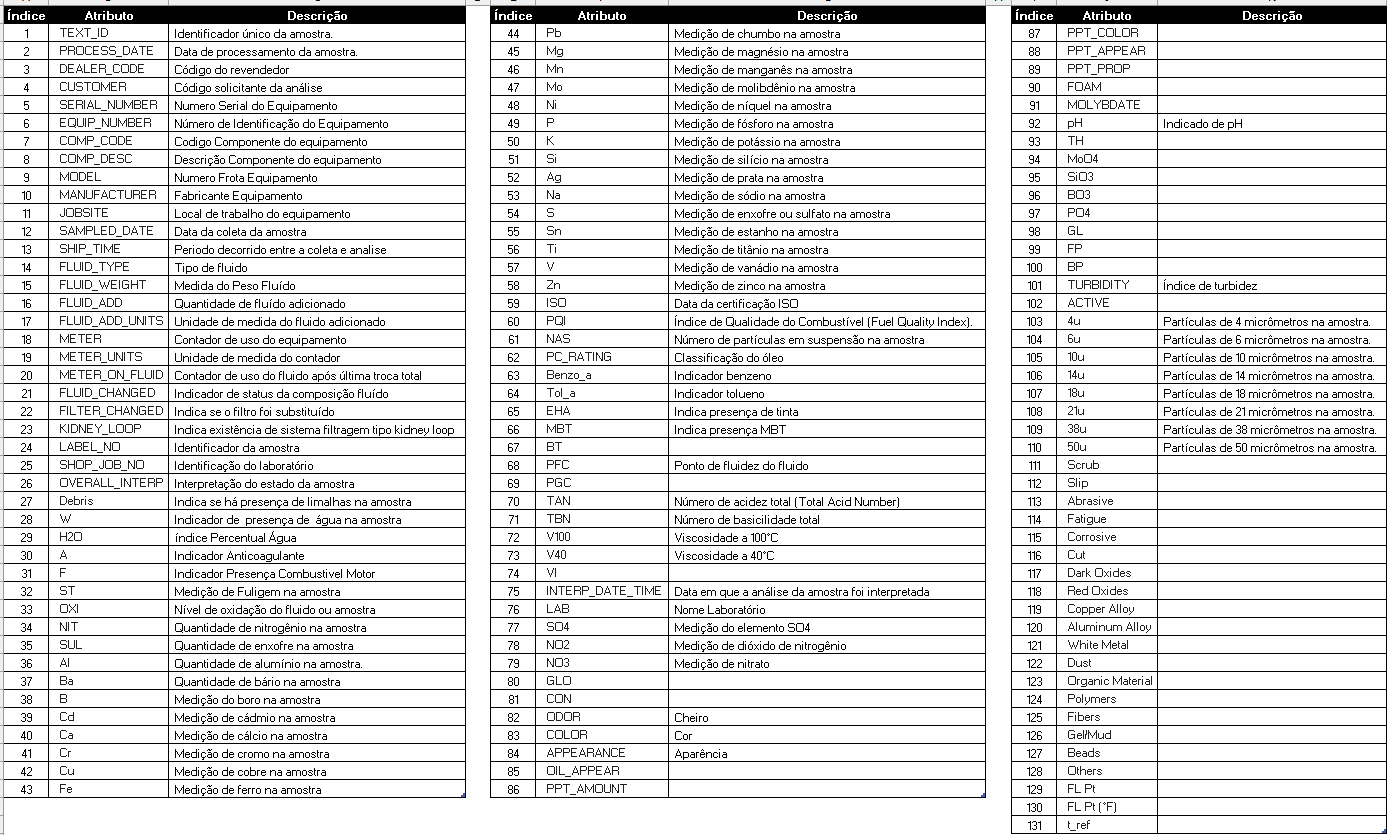

O dataset utilizado já está tratado e redimensionado para 35.595 linhas e 62 colunas.

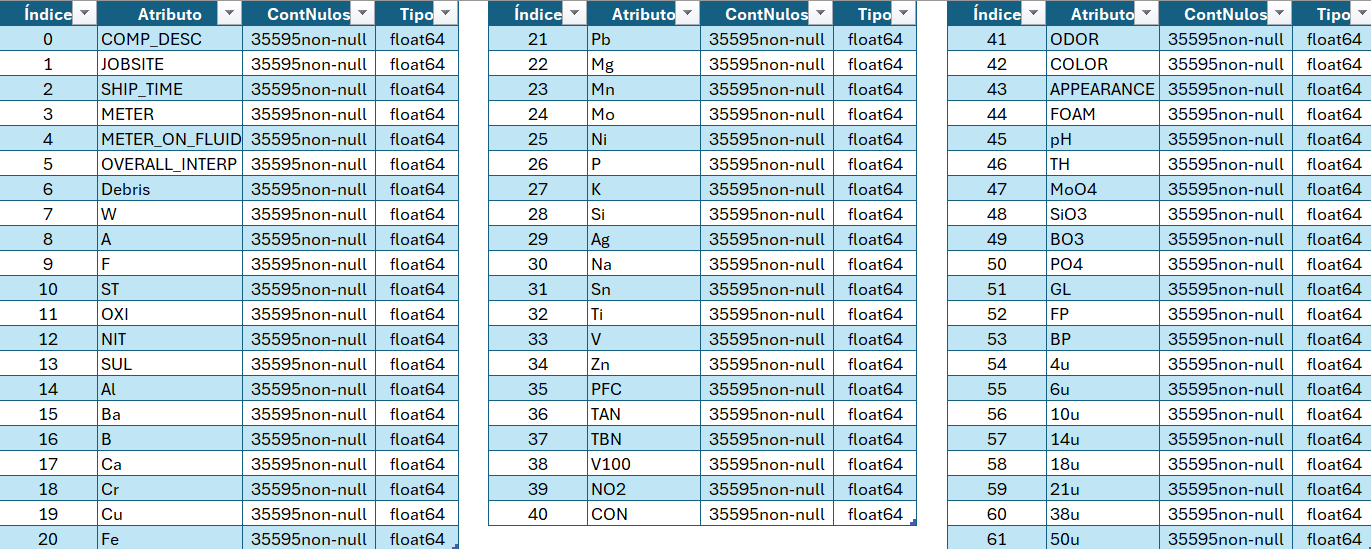





### 3.2) Carga dos dados
O arquivo carregado já possui alguns processos de tratamento/limpeza de dados, que foi realizado na sprint de Análise de Dados e Boas Práticas e salvo em um novo arquivo.

Por esse motivo, foi necessário incluir uma linha para exclusão da coluna de índice que foi exportada junto com o dataset.



In [3]:

# Salvamento da URL do local do dataset em variável
url_dados = "https://github.com/Romario76/Pos-PUCRJ-Data-Science-Analytics/raw/refs/heads/SPRINT_ML-Analytics/Analise_lub_tratado.xlsx"

# Criação do dataframe (aprox. 30s)
df = pd.read_excel(url_dados, sheet_name='Sheet1')


#Excluindo coluna Índice criado no dataframe original que foi exportado
df = df.drop(["Unnamed: 0"],axis=1)


Em seguida, é executado uma verificação básica para garantir que os dados foram carregados corretamente.

In [4]:
# Verificações iniciais
display(df.sample(10))
print("\nFormato:", df.shape)
print("\nTipos:")
print(df.dtypes)
print("\nValores ausentes por coluna:")
print(df.isna().sum())


,COMP_DESC,JOBSITE,SHIP_TIME,METER,METER_ON_FLUID,OVERALL_INTERP,Debris,W,A,F,...,FP,BP,4u,6u,10u,14u,18u,21u,38u,50u
19024,12,-1,0,6500.0,368.0,2,1,1,-1,-1,...,0,0,0,0,0,0,0,0,0,0
2974,52,5,0,7139.0,7139.0,2,-1,-1,-1,-1,...,-36,107,0,0,0,0,0,0,0,0
16026,25,-1,0,42080.0,211.0,2,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
32522,35,15,8,22803.0,611.0,1,4,3,-1,-1,...,0,0,0,0,0,0,0,0,0,0
19490,13,-1,8,4878.0,868.0,2,1,1,-1,-1,...,0,0,0,0,0,0,0,0,0,0
22624,26,11,0,42444.0,248.0,0,1,1,-1,-1,...,0,0,0,0,0,0,0,0,0,0
9146,61,-1,0,6972.0,984.0,2,1,1,0,-1,...,0,0,962,172,39,8,3,2,0,0
30424,45,5,6,33793.0,1501.0,1,4,1,-1,-1,...,0,0,0,0,0,0,0,0,0,0
34423,61,-1,2,29233.0,3662.0,1,1,1,0,-1,...,0,0,1,1,1,1,1,1,1,1
34443,60,10,0,0.0,0.0,1,1,1,0,-1,...,0,0,43918,12736,2833,472,125,47,1,0



Formato: (35595, 62)

Tipos:
COMP_DESC           int64
JOBSITE             int64
SHIP_TIME           int64
METER             float64
METER_ON_FLUID    float64
                   ...   
14u                 int64
18u                 int64
21u                 int64
38u                 int64
50u                 int64
Length: 62, dtype: object

Valores ausentes por coluna:
COMP_DESC         0
JOBSITE           0
SHIP_TIME         0
METER             0
METER_ON_FLUID    0
                 ..
14u               0
18u               0
21u               0
38u               0
50u               0
Length: 62, dtype: int64



### 3.1 Análise exploratória resumida (EDA)

Em resumo, o dataset possui muitos valores nulos, valores com alta variabilidade, dados incosistentes ou despadronizados. A análise exploratória revelou, também, algumas correlações entre as características dos fluidos analisados e a eficácia de visualizações para interpretação do comportamento dos atributos em relação aos estados (resultados) dos fluidos.

---



O atributo alvo (OVERALL_INTERP) possui três classes, que indicam o estado da amostra, sendo uma classe com frequência menor do que as outras duas, ou seja, o problema precisará tratar o desbalanceamento das classes, para evitar viéses na predição.

OBS:
- A classe "No comment" foi descartada do dataset, por ser um valor de erro de input e em quantidade desprezível.

**Gráfico da fase exploratória inicial;**

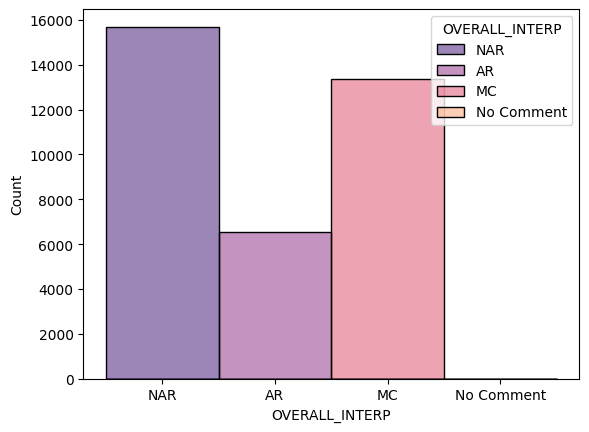

Na AED, as hipóteses levantandas foram testadas e três das quatro hipóteses foram validadas:

**O estado da amostra está relacionada ao tempo de utilização (horas)?**

  ***Validado**. Os fluidos se degradam conforme o tempo de uso aumenta, sendo mais relevante o tempo decorrido após a última troca, do que o tempo de operação do equipamento/componente.*

**O local/componente de aplicação influencia no resultado?**
  
  ***Validado**. Dependendo o tipo de componente onde o fluido é aplicado, a necessidade de troca se faz necessário com maior frequência, pois atinge níveis críticos em menor tempo.*

**Qual a influência do site de operação do equipamento na análise?**
  
  ***Validado**. A análise demonstrou que alguns sites a quantidade de testes é bem superior a outras e a proporção de amostras classificadas como críticas também é maior nestes locais.*

**Existe correlação entre o fabricante do lubrificante e o resultado da análise?**

  ***Não validado**. Não há atributo específico para inserção deste dado, sendo assim, o fabricante é informado no atributo 'Tipo de Fluido', de forma totalmente despadronizada, tanto pela ausência, quanto pela forma/escrita.*


---



A seguir, é apresentado as principais análises realizadas, de acordo com o problema proposto. Estruturado da seguinte forma:
- Resumo do insight obtido
- Código utilizado para geração do gráfico
- Imagem do gráfico gerado

---


*OBS: devido à transformação dos atributos categóricos na sprint anterior, os gráficos são antes do tratamento, para melhor visualização dos nomes dos atributos e melhor entendimento das observações encontradas*


3.3.1) Análise da distribuição em função dos componentes onde os fluidos são aplicados. Considerando as proporções de resultados Críticos (MC), o componente pode influenciar no resultado.



```
plt.figure(figsize=(15,10))
sns.histplot(df, x='COMP_DESC', hue='OVERALL_INTERP', palette='magma', multiple='stack',shrink=.8,).xaxis.set_tick_params(rotation=90)
```

**Gráfico Distribuição Componentes x Atributo Alvo**

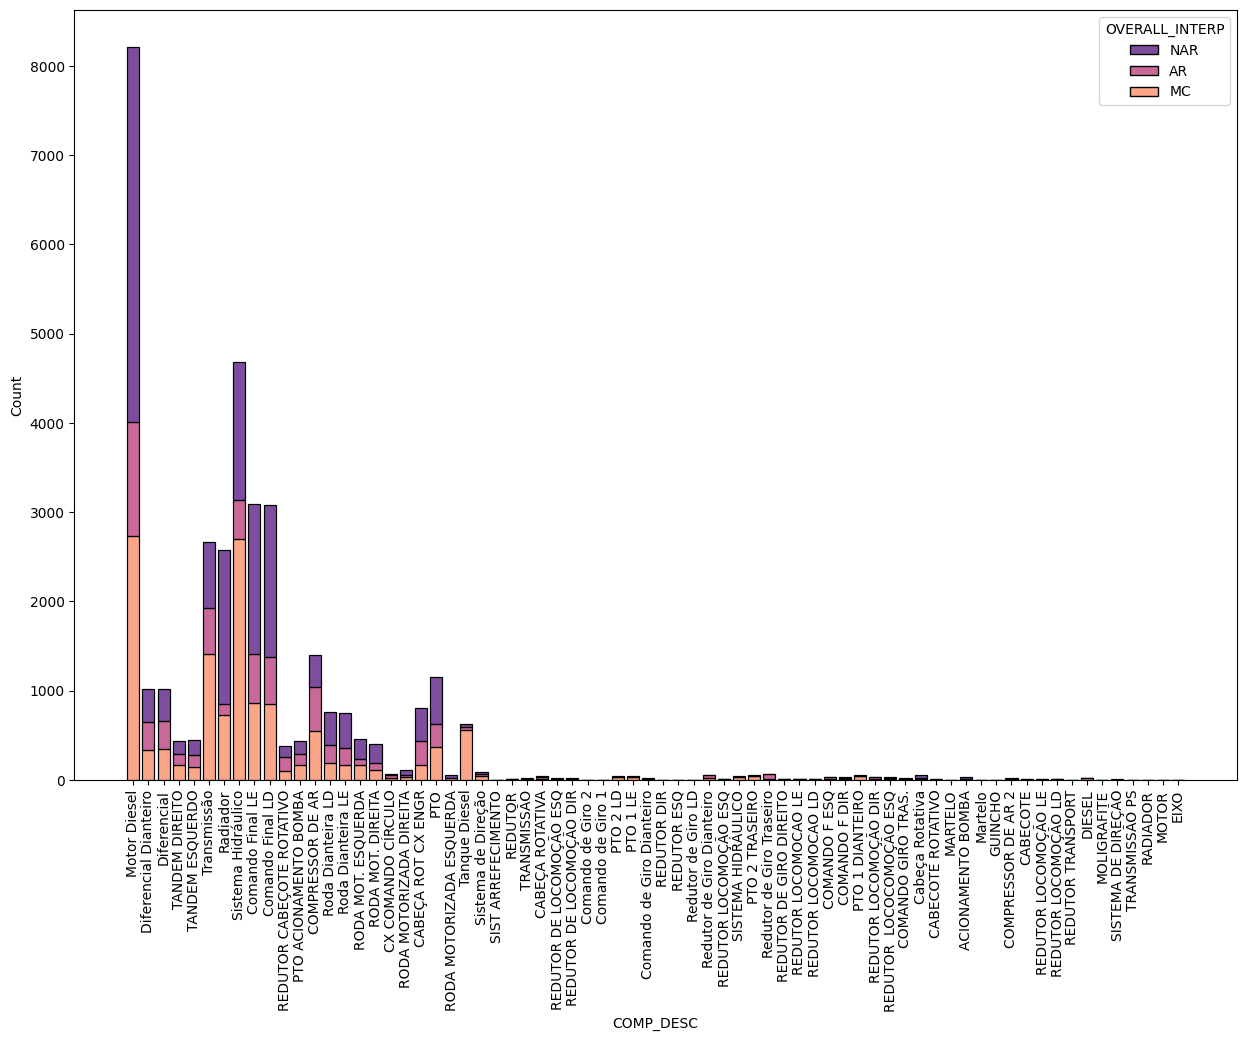

---
3.3.2) Lembrando que o atributo `JOBSITE` indica o local de operação dos
equipamento, é possível observar que alguns possuem quantidades maiores de amostras analisadas, indicando onde há mais equipamentos operando ou que necessitam de maior frequência no acompanhamento dos fluidos.

Quanto à proporção dos resultados, em alguns sites, os resultados Crítico (MC) são maiores. Se somados aos Atenção (AR), sugerindo que o site de operação afeta a qualidade/vida dos fluidos.

```
plt.figure(figsize=(15,10))
sns.histplot(df, x='JOBSITE', hue='OVERALL_INTERP', palette='magma', multiple='stack',shrink=.8,).xaxis.set_tick_params(rotation=90)
```
**Gráfico Análise Local de Operação x Atributo alvo**

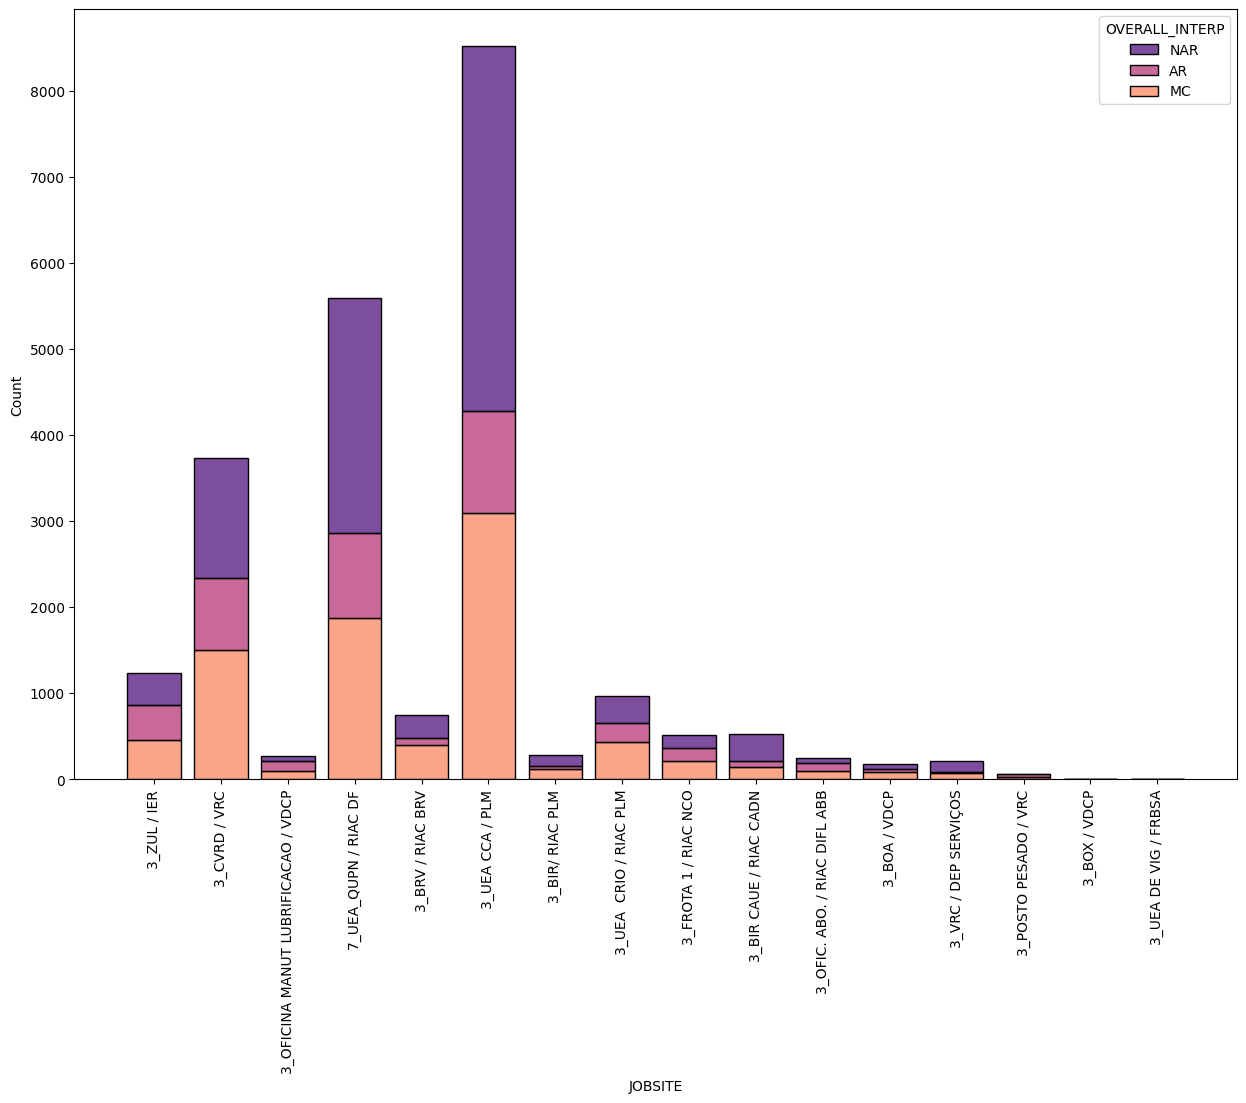




---


3.3.3) Não há um atributo específico para informar o fabricante do fluido da amostra. O atributo `FLUID_TYPE` não é utilizado para a finalidade de indicar o tipo de fluido (arrefecimento, óleo hidráulico, óleo lubrificante , etc), e sim para inserir o fabricante e/ou especificação/marca do fluido.

Porém não há padronização ou validação dos dados inputados, pois há informações variadas, tais como, órgão de normatização ('SAE'), base de lubrificante ('mineral'), nomes comerciais dos produtos (Corena S8), erros de digitação nos nomes de fabricantes ('LYBRAX'), dentre outros.

Desta forma, não é possível fazer uma análise de relação entre o fabricante do fluido e o resultado da amostra.


```
plt.figure(figsize=(15,30))
sns.histplot(df, y='FLUID_TYPE', hue='OVERALL_INTERP', palette='magma', multiple='stack',shrink=.8,)
```
**Gráfico Atributo Tipo do Fluido**

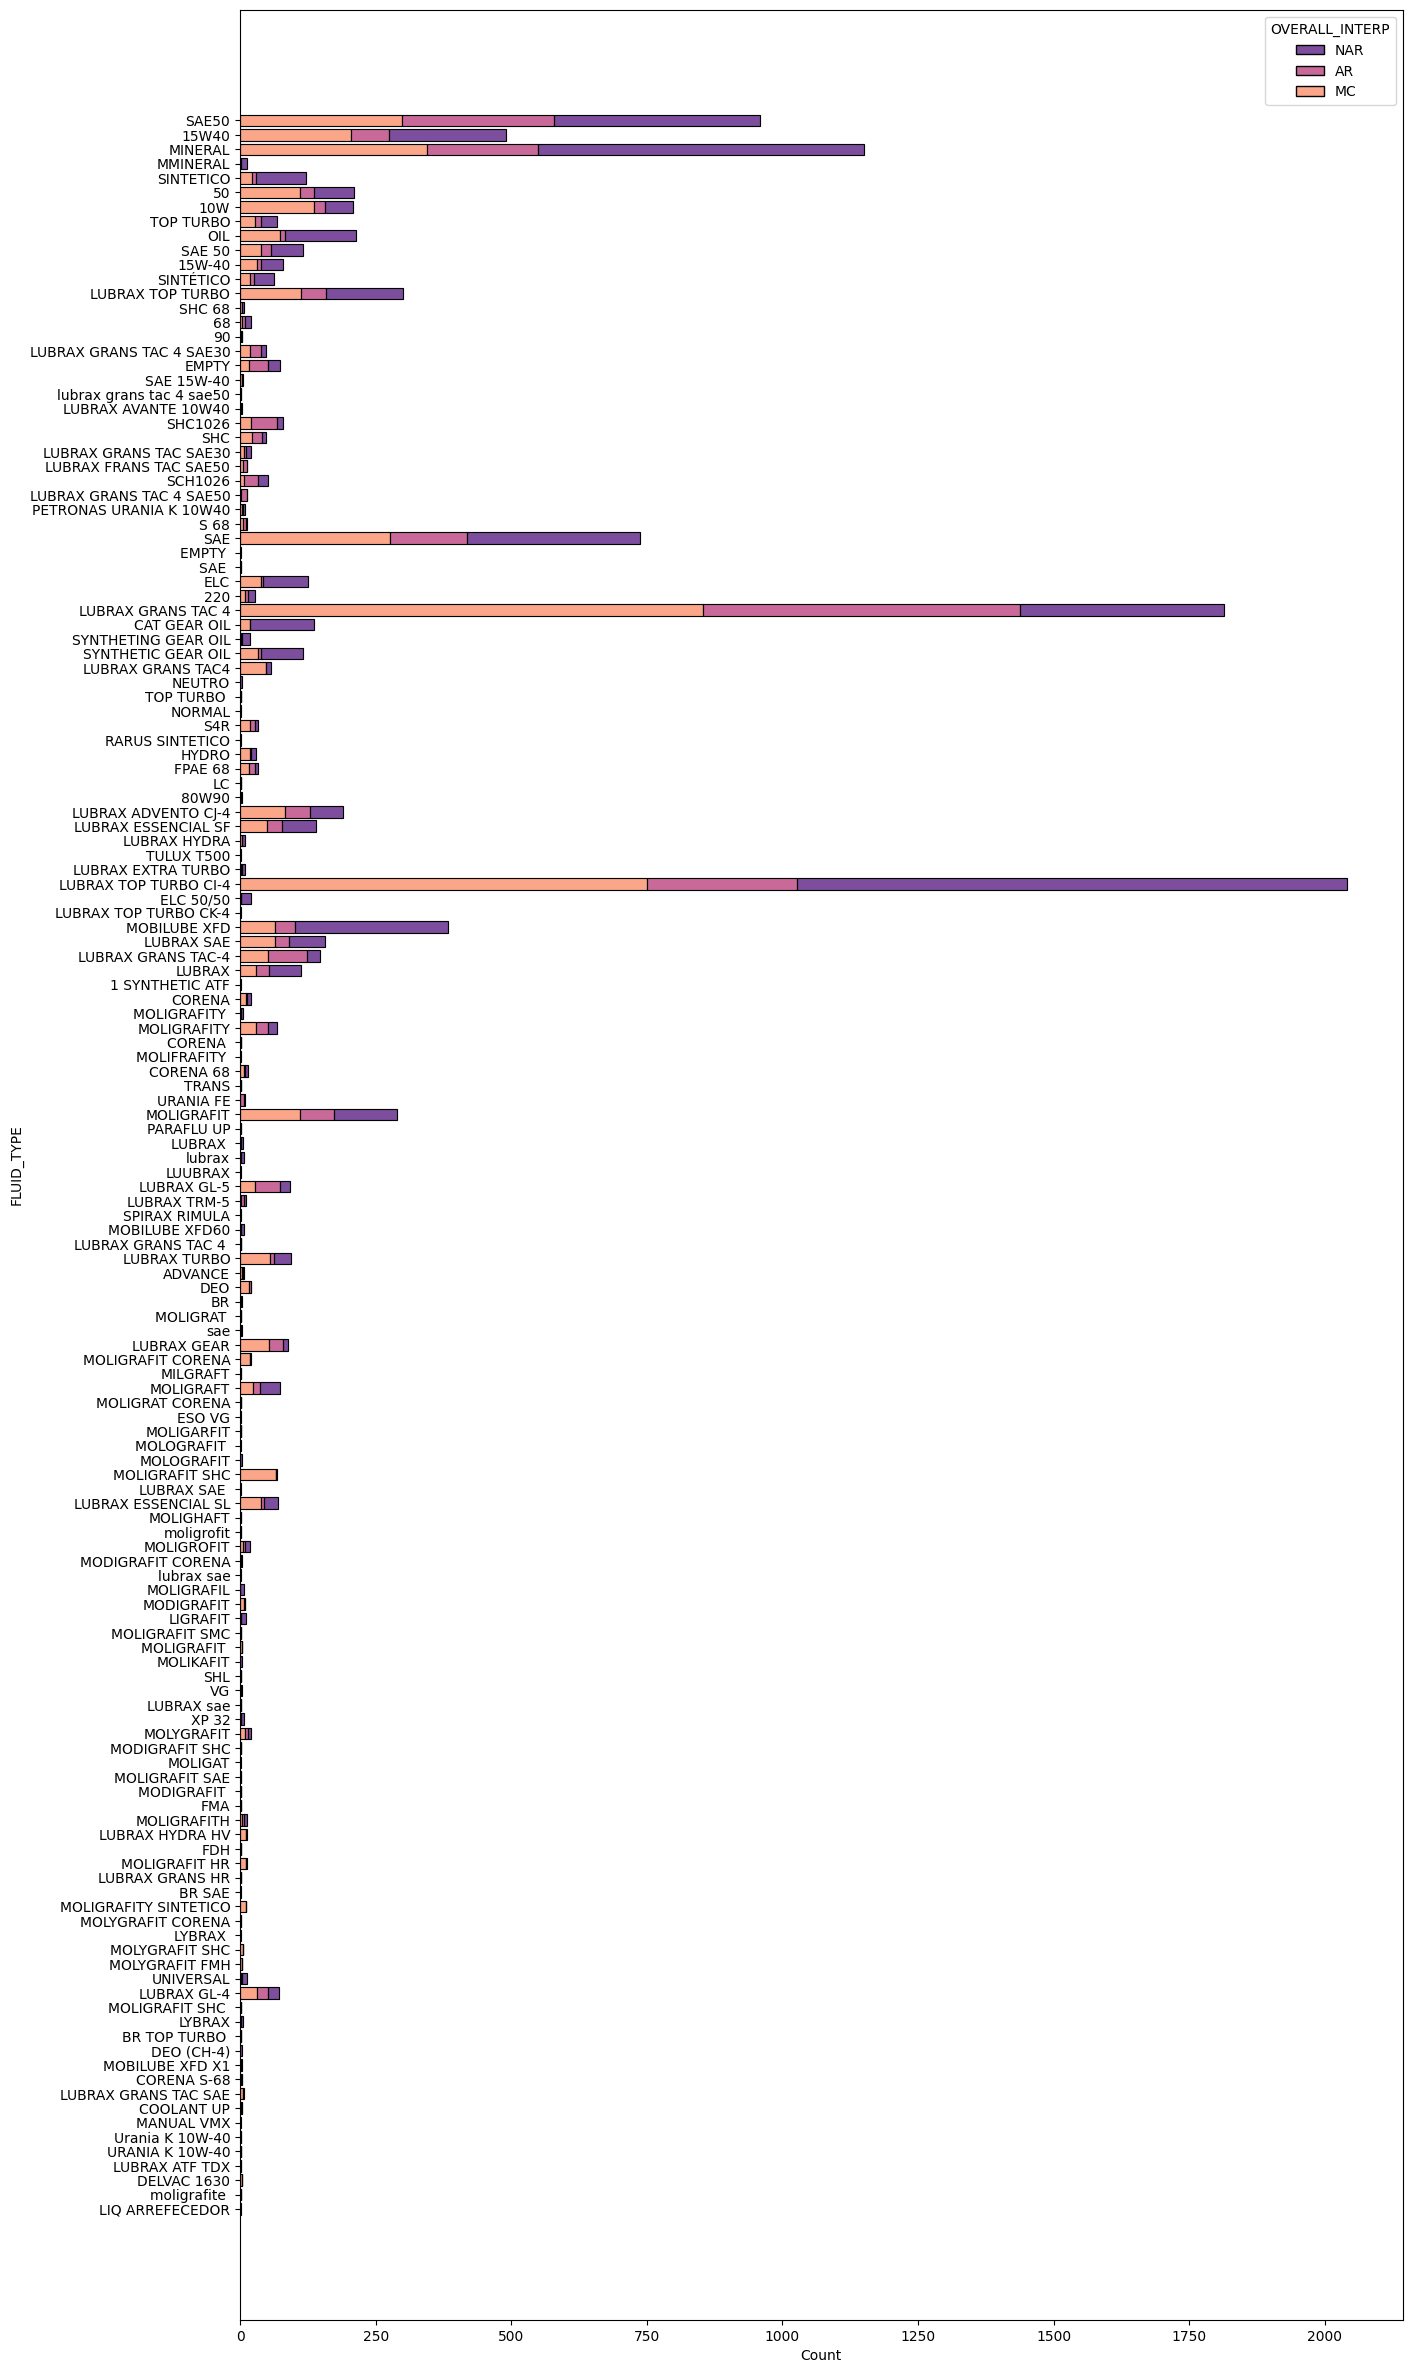



---


3.3.4) Verificação da relação/influência das variáveis de tempo de uso do equipamento nos resultados.

Os gráficos confirmam que existe uma relação da degradação da amostra conforme o tempo, algo até já esperado, sendo que atributo `METER_ON_FLUID` parece ser o mais adequado para uso em modelos preditivos, pois especifica o tempo de utilização após a última troca do fluido.


```
#utilizado as variáveis 'METER' E 'METER_ON_FLUID', que representam tempo de uso (equipamento e fluio)
f, axes = plt.subplots(1,2, figsize=(15, 15), sharex=True, layout='tight')
sns.boxplot(df,x='OVERALL_INTERP',y='METER', hue='OVERALL_INTERP',palette='magma',ax=axes[0])
sns.boxplot(df,x='OVERALL_INTERP',y='METER_ON_FLUID', hue='OVERALL_INTERP',palette='magma',ax=axes[1])
```

**Gráficos de Tempo de Operação do Equipamento**

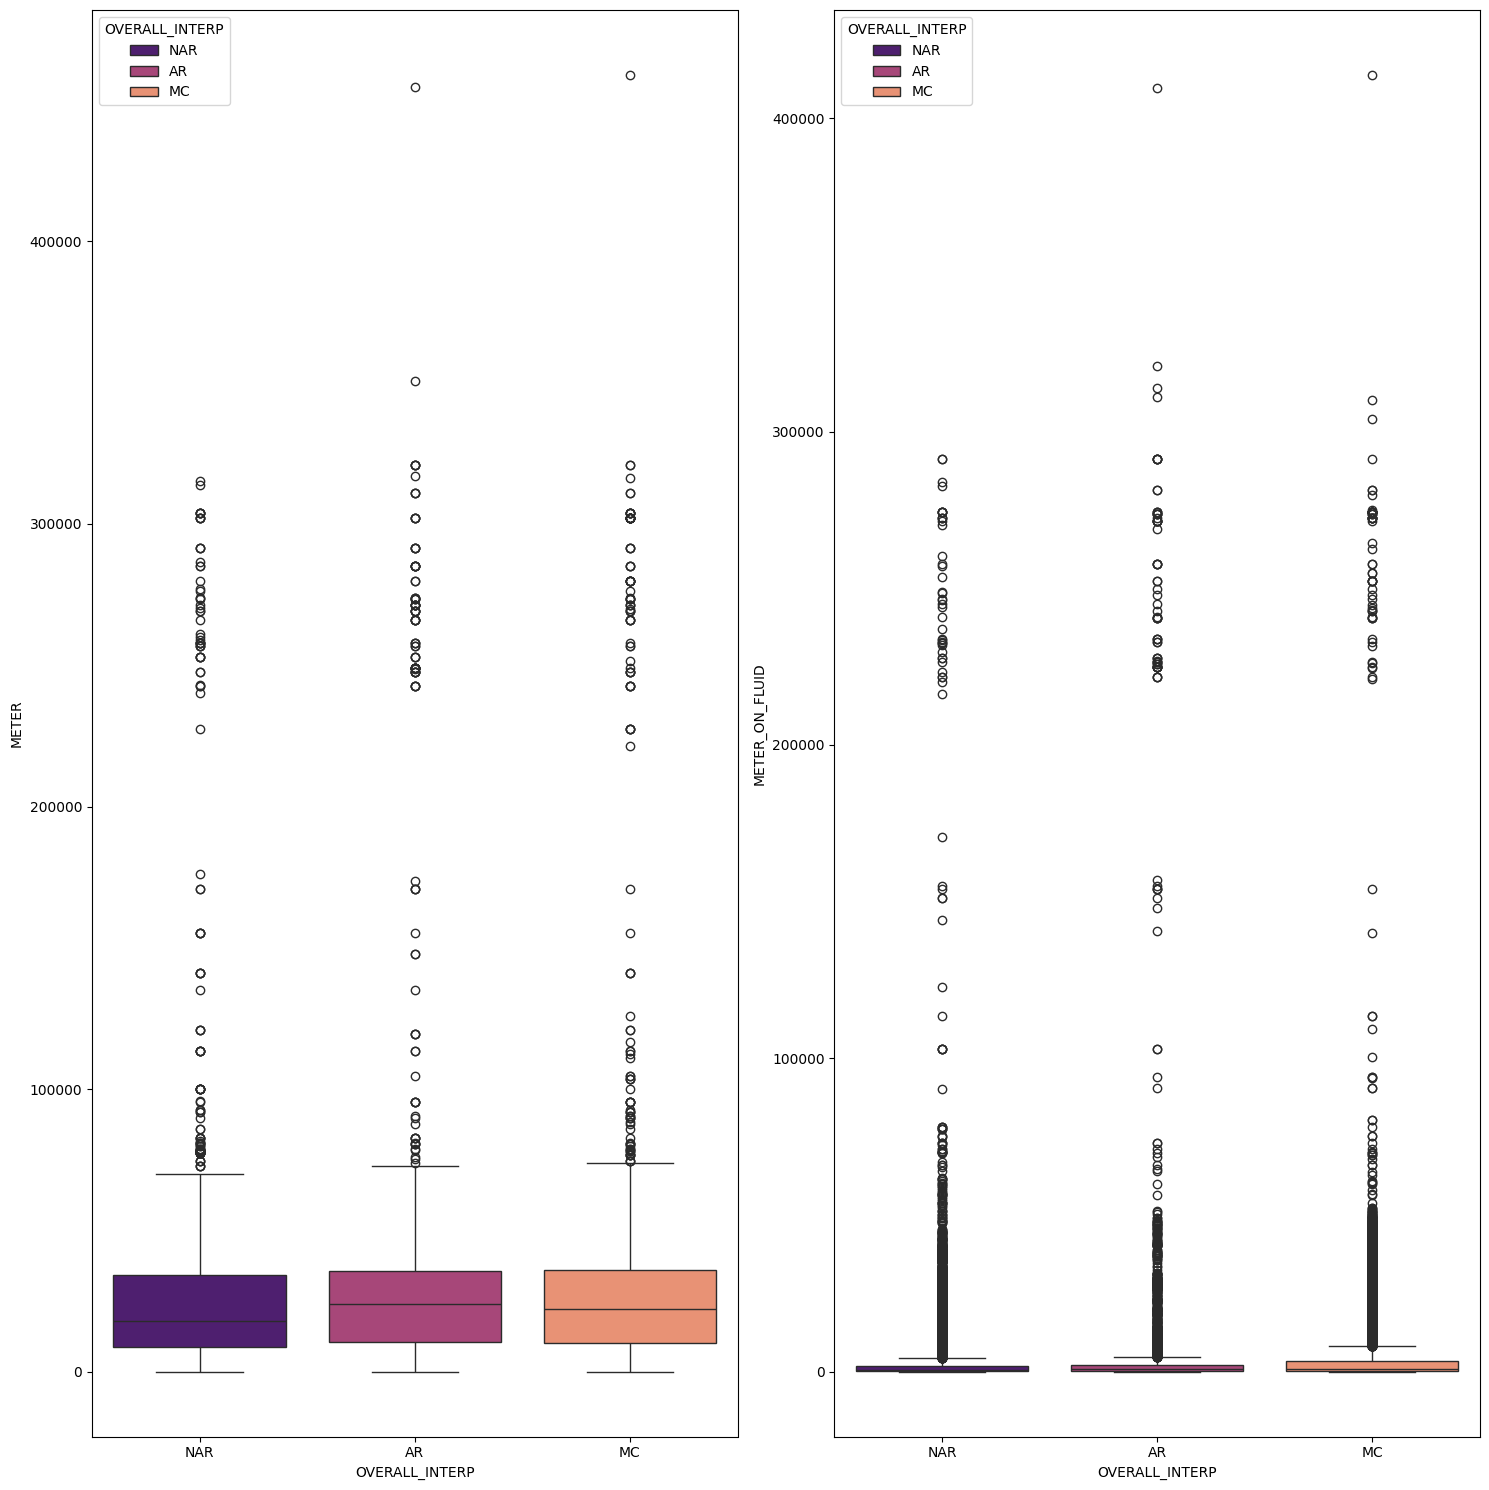


## 4. Definição do target, variáveis e divisão dos dados


Por se tratar de um problema com classes desbalanceadas, a primeira estratégia foi aplicar `UnderSampling` na base de treino, realizado com sucesso, conforme a saída apresentada.


A aplicação do `UnderSampling` após train_test_split evita vazamento de dados, pois, se aplicar antes, pode acabar removendo amostras importantes da classe majoritária que deveriam estar na base de teste. Também, mantém a distribuição real na base de teste, porque isso é essencial para avaliar o desempenho do modelo em dados reais e desbalanceados, como ele encontrará em produção.

Para definição pelo uso do UnderSampling, foi realizado um teste utilizando `LogisiticRegression` (Baseline). Os métodos de `OverSampling` (Random e SMOTE) elevaram muito o tempo, porém o desempenho de predição não teve melhora significativa. O `UnderSamplig` melhorou as pontuações e trouxe uma redução de tempo de processamento.

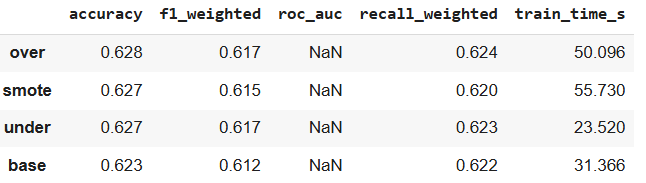


In [5]:
#Tipo de problema: CLASSIFICAÇÃO

#Definição do target
target = "OVERALL_INTERP"
features = [c for c in df.columns if c not in [target]]
print("Tipo do problema: CLASSIFICAÇÃO")
print("Target:", target)
print("N features:", len(features))

# Divisão dos dados com estratificação do target, devido à existência de uma classes desblanceadas
X = df[features].copy()
y = df[target].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=y)

# Undersampling
rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = rus.fit_resample(X, y)

print("Treino:", X_train.shape, "Treino resampled:", X_train_under.shape,"| Teste:", X_test.shape)


Tipo do problema: CLASSIFICAÇÃO
Target: OVERALL_INTERP
N features: 61
Treino: (24916, 61) Treino resampled: (19632, 61) | Teste: (10679, 61)



## 5. Tratamento de dados e **Pipeline** de pré-processamento

Ações realizadas na sprint de Análise de Dados e Boas Práticas:

* Tratamento de nulos;
    * Exclusão de atributos com grande volume de dados nulos;
    * Exclusão de linhas onde o atributo taget possui valor nulo;
    * Preenchimento de valores nulos dos atributos numéricos por zero.
* *Feature selection* inicial: avaliação de atributos sem dados, informações de data e identificação (laboratório, etiqueta, id, etc), que não estão relacionados diretamente à qualidade da amostra;
* Transformação dos valores categóricos: utilizado `OrdinalEncoder`, pois a classe target possui uma ordem sequencial, apesar de terem outras que não têm. Porém, há atributos multicategóricos (p.e., `COMP_DESC`) e o uso do `OneHotEncoding` poderia afetar significativamente o desempenho do modelo, já que cria uma coluna para cada categoria.

Nesta sprint, foi incluído mais um *featuring select*, dessta vez através do algoritmo `SelectKBest`, que identifica os K melhores atributos através de uma função de pontuação. A função utilizada é a `f_classif`, pelas características do dadaset e do problema.

Também serão treinados modelos utilizando o dataset normalizado e padronizado para avaliação.


In [6]:
#preparando as funções de pré-processamento

#Seleção de atributos (a quantidade definida representa 1/3 do total de atributos).
#O objetivo reduzir tempo de processamento, mas prejuízo à qualidade de predição modelo
feature_selection = ('kBest',SelectKBest(score_func=f_classif, k=20))

#Padronização
standard_scaler = ('StandardScaler', StandardScaler())

#Normalização
min_max_scaler = ('MinMaxScaler', MinMaxScaler())



## 6. Baseline e modelos candidatos
Para Baseline, foi escolhido o algoritmo `LogisticRegression`, por ser simples e um dos recomendados para datasets com classes desbalanceadas.

Para avaliação e escolha de qual algoritmo utilizar, foram escolhidos cinco algoritmos que também possuem boa performance em problemas de classificação com dataset desbalanceado.

In [7]:
# Criando os elementos do pipeline

# Baseline
baseline = LogisticRegression(max_iter=1000, solver="saga", class_weight="balanced", random_state=SEED)

# Algoritmos que serão utilizados para comparação com baseline

#Criando os modelos 'tradicionais'
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier(class_weight="balanced"))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier(class_weight="balanced")
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
bases.append(LogisticRegression(max_iter=1000, solver="saga", class_weight="balanced"))
bases.append(cart)
bases.append(knn)

# Criando os ensembles
bagging = ('Bag', BaggingClassifier(estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(class_weight="balanced", n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features, class_weight="balanced"))


Pipelines garantem que o mesmo fluxo de etapas (pré-processamento, transformação, modelagem, etc.) seja aplicado de forma consistenteo que facilita a reprodução dos resultados, tanto em ambientes de teste quanto em produção.

O `Pipeline` também integra bem com métodos de validação cruzada, aplicando todas as etapas corretamente em cada fold.

Permite ajustar hiperparâmetros de diferentes etapas (ex: pré-processamento e modelo) de forma conjunta usando `GridSearchCV` ou `RandomizedSearchCV`.

Pipelines são facilmente serializáveis (via `joblib` ou `pickle`), o que facilita o deploy do modelo e reduz o risco de inconsistência entre o ambiente de desenvolvimento e produção.

Cada etapa do pipeline é um módulo independente, o que facilita testes, substituições e melhorias. Exemplo: trocar um `StandardScaler` por um `MinMaxScaler` sem alterar o restante do fluxo.

Ao encapsular todas as etapas, o pipeline garante que transformações sejam feitas dentro dos folds de validação, evitando vazamento de dados.

In [8]:
# Listas para armazenar os pipelines
pipelines = []

#Base original
pipelines.append(('KNN-orig',Pipeline([knn])))
pipelines.append(('CART-orig',Pipeline([cart])))
pipelines.append(('Bag-orig',Pipeline([bagging])))
pipelines.append(('RF-orig',Pipeline([random_forest])))
pipelines.append(('ET-orig',Pipeline([extra_trees])))

#Base padronizada
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))

#Base normalizada
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))

#Base com feature selection
pipelines.append(('KNN-fs', Pipeline([feature_selection, knn])))
pipelines.append(('CART-fs', Pipeline([feature_selection, cart])))
pipelines.append(('Bag-fs', Pipeline([feature_selection, bagging])))
pipelines.append(('RF-fs', Pipeline([feature_selection, random_forest])))
pipelines.append(('ET-fs', Pipeline([feature_selection, extra_trees])))

#Base com feature selection e padronizada
pipelines.append(('KNN-fspadr', Pipeline([feature_selection, standard_scaler, knn])))
pipelines.append(('CART-fspadr', Pipeline([feature_selection, standard_scaler, cart])))
pipelines.append(('Bag-fspadr', Pipeline([feature_selection, standard_scaler, bagging])))
pipelines.append(('RF-fspadr', Pipeline([feature_selection, standard_scaler, random_forest])))
pipelines.append(('ET-fspadr', Pipeline([feature_selection, standard_scaler, extra_trees])))

#Base com feature selection e normalizada
pipelines.append(('KNN-fsnorm', Pipeline([feature_selection, min_max_scaler, knn])))
pipelines.append(('CART-fsnorm', Pipeline([feature_selection, min_max_scaler, cart])))
pipelines.append(('Bag-fsnorm', Pipeline([feature_selection,min_max_scaler, bagging])))
pipelines.append(('RF-fsnorm', Pipeline([feature_selection, min_max_scaler, random_forest])))
pipelines.append(('ET-fsnorm', Pipeline([feature_selection, min_max_scaler, extra_trees])))



### 6.1 Treino e avaliação rápida (baseline vs candidatos)
Para a avaliação, foram utilizadas as métricas balanced_accuracy, F1_score (média) e Recall_score (média), todas aplicáveis em problemas de classificação e com recursos para avaliar classes desbalanceadas.


In [9]:
results = {}

# Baseline
t0 = time.time()
baseline.fit(X_train_under, y_train_under)
t1 = time.time()
y_pred = baseline.predict(X_test)
results["baseline"] = evaluate_classification(y_test, y_pred)
results["baseline"]["train_time_s"] = round(t1 - t0, 3)

# Candidatos
for name, pipe in pipelines:
    t0 = time.time()
    pipe.fit(X_train_under, y_train_under)
    t1 = time.time()
    y_pred = pipe.predict(X_test)
    results[name] = evaluate_classification(y_test,y_pred)
    results[name]["train_time_s"] = round(t1 - t0, 3)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


**Apresentação dos resultados de avaliação dos modelos treinados**

Os modelos baseados em árvore de decisão obtiveram os melhores resultados, sugerindo que o dataset possui dados não lineares.

O *ensemble* `Bagging` com `DecisionTreeClassifier`, executado com o dataset "original", normalizado e padronizado, obteve as maiores pontuações, contudo também demandou mais tmpo de processamento.

O `RandomForest` executado no dataset normalizado vem logo em seguida e com melhor equilíbrio entre métrica e tempo de execução.

In [19]:

df_results = pd.DataFrame(results).T
df_results.sort_values(by=["média","train_time_s"], axis=0, ascending=False)

,accuracy,f1_weighted,recall_weighted,média,train_time_s
Bag-orig,0.941,0.929,0.929,0.933,48.449
Bag-norm,0.940,0.928,0.929,0.932,48.493
Bag-padr,0.938,0.926,0.926,0.930,48.585
RF-norm,0.934,0.921,0.922,0.926,3.668
RF-orig,0.934,0.921,0.922,0.925,3.648
RF-padr,0.932,0.919,0.920,0.923,3.723
ET-norm,0.919,0.903,0.904,0.909,3.309
ET-orig,0.918,0.902,0.903,0.908,4.288
RF-fs,0.916,0.900,0.901,0.905,2.819
RF-fsnorm,0.915,0.899,0.900,0.905,2.563


**Gráficos para visualização dos resultados, por métrica utilizada**
* F1 Score (Balanceado)
* Balanced Accuracy
* Recall (balanceado)

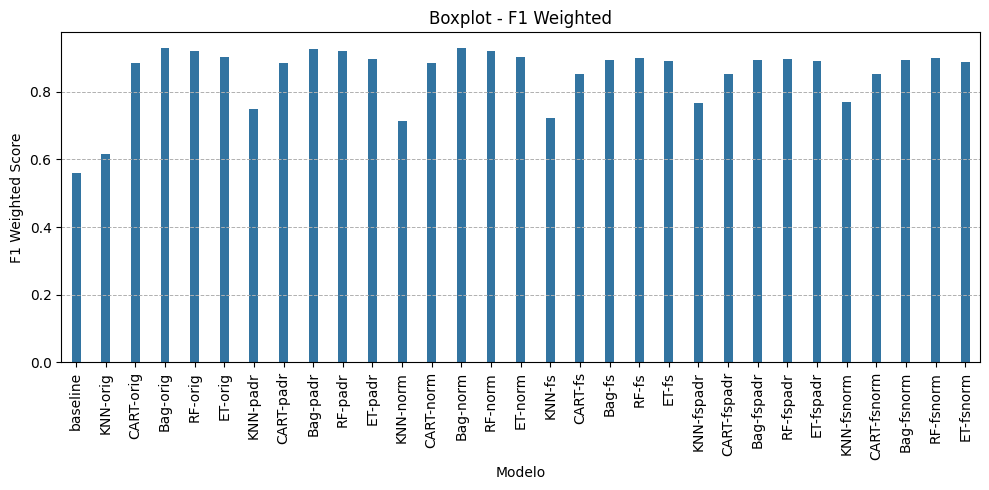

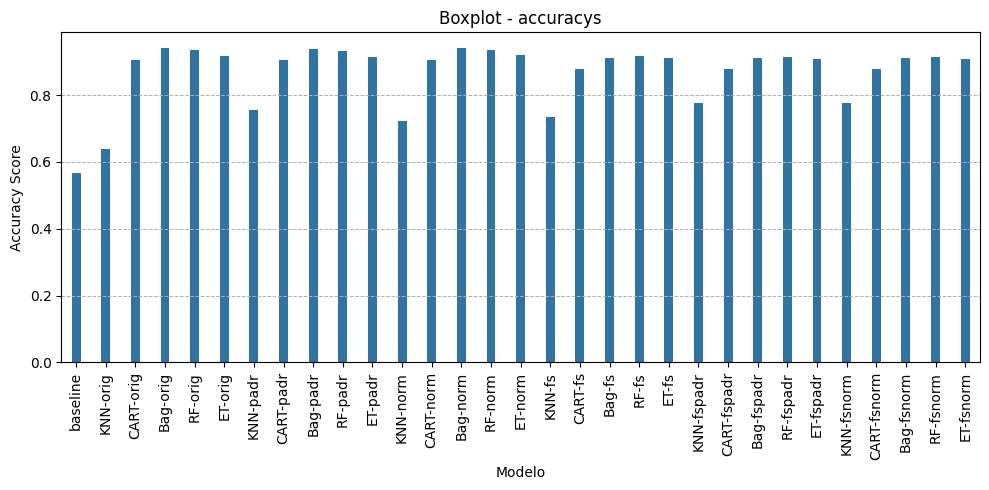

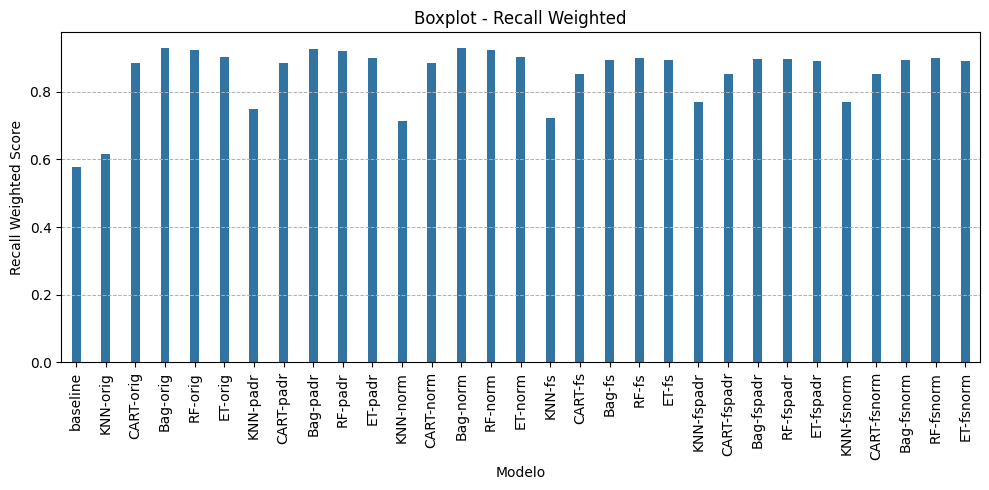

In [ ]:

fig = plt.figure(figsize=(10,5))
sns.barplot(x=df_results.index, y=df_results['f1_weighted'],width=0.3)
plt.xticks(rotation=90) # Rotate labels for better readability
plt.title('Boxplot - F1 Weighted')
plt.xlabel('Modelo')
plt.ylabel('F1 Weighted Score')
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.show()

fig = plt.figure(figsize=(10,5))
sns.barplot(x=df_results.index, y=df_results['accuracy'],width=0.3)
plt.xticks(rotation=90) # Rotate labels for better readability
plt.title('Boxplot - accuracys')
plt.xlabel('Modelo')
plt.ylabel('Accuracy Score')
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.show()

fig = plt.figure(figsize=(10,5))
sns.barplot(x=df_results.index, y=df_results['recall_weighted'],width=0.3)
plt.xticks(rotation=90) # Rotate labels for better readability
plt.title('Boxplot - Recall Weighted')
plt.xlabel('Modelo')
plt.ylabel('Recall Weighted Score')
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.show()


## 7. Validação e Otimização de Hiperparâmetros
Para essa etapa, foi utilizado o modelo RF_norm (`RandomForest` com Normalização), pelo equílibrio apresentado entre desempenho e tempo.

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
model = Pipeline([min_max_scaler,random_forest])
param_dist = {
    "RF__n_estimators": randint(100, 400),
    "RF__max_depth": randint(3, 20),
    "RF__min_samples_split": randint(2, 10)
}
scorer = "f1_weighted"

# Executar busca aleatória (exemplo geral — ajuste para seu caso)
search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=cv, scoring=scorer, random_state=SEED, n_jobs=-1, verbose=1)
search.fit(X_train_under, y_train_under)
print("Melhor score (CV):", search.best_score_)
print("Melhores parâmetros:", search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhor score (CV): 0.7934068302185315
Melhores parâmetros: {'RF__max_depth': 14, 'RF__min_samples_split': 2, 'RF__n_estimators': 148}



## 8. Avaliação final, análise de erros e limitações



              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1963
           1       0.92      0.72      0.81      4008
           2       0.83      0.96      0.89      4708

    accuracy                           0.86     10679
   macro avg       0.86      0.86      0.86     10679
weighted avg       0.87      0.86      0.86     10679



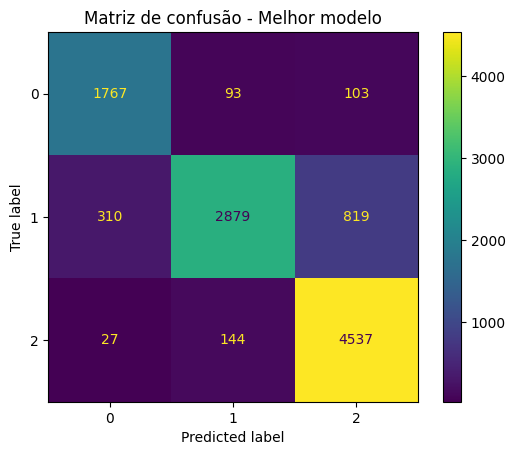

In [ ]:

best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
print(classification_report(y_test, y_pred))
try:
    ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
    plt.title("Matriz de confusão - Melhor modelo")
    plt.show()
except Exception as e:
    print("Não foi possível plotar a matriz de confusão:", e)


**Comparativo Baseline x Melhor modelo**

Para o problema apresentado, o Baseline (`LogisticRegression`) se mostrou limitado, devido ao tamanho do dataset, necessitando aumentar significativamente o limite de iterações, levando a um aumento no tempo de processamento. No processo, mesmo com um valor elevado para `max_iter` o desempenho ficou bem abaixo dos outros modelos.

O Melhor modelo escolhido e validado apresentou bom desempenho no treino e se manteve na validação. O tempo de execução não causar muito impacto, mesmo para bases maiores, que é inerente ao problema tratado neste projeto, a análise de amostras de fluidos.


**Análise de Limitações:**

1. Desequilíbrio entre as classes: pode afetar a capacidade do modelo de aprender os padrões de algumas classes.
2. O modelo apresenta boa capacidade para generalização, pois todas as classes ficaram com F1 equilibrado.
3. Tempo de execução: Modelos com melhor desempenho podem ter maior custo computacional. Esse foi um dos indicadores que definiu a escolha pelo modelo RF-norm (`RandomForrest` com dados Normalizados), já que o modelo com `Bagging` apresentou alto custo para um pequeno ganho em desempenho.




## 9. Engenharia de atributos

* Exclusão de atributos sem dados ou com grande volume de dados nulos
* Exclusão de atributos de informações de data ou identificação (laboratório, etiqueta, id, etc), que não estão relacionados diretamente à qualidade da amostra;
* Feature selection: algoritmo SelectKBest, que identifica os K melhores atributos através de uma função de pontuação. A função utilizada é a f_classif, pelas características do dadaset e do problema.

* Transformação dos valores categóricos (encoding): utilizado OrdinalEncoder, pois a classe target possui uma ordem sequencial, apesar de terem outras que não têm. Porém, há atributos multicategóricos (p.e., COMP_DESC) e o uso do OneHotEncoding poderia afetar significativamente o desempenho do modelo, já que cria uma coluna para cada categoria.



## 10. Conclusões e próximos passos

Resumo dos Resultados:
O modelo RF-norm apresenta o melhor equilíbrio entre desempenho e tempo de execução. Ou seja, desempenho com eficiência.
F1 treino: 0.921
F1 teste: 0.86
Tempo de execução: 3.609 segundos

Trade-offs Observados

* Modelos mais precisos, como os criados com `Bagging` têm maior custo computacional, podendo ser inviável para grandes dados.
* Classes com baixo desempenho sugerem necessidade de refinamento.

Propostas de Melhoria Futura

* Ajustar o desenho do banco de dados para qualificar melhor os dados, retirando o que não tem uso e otimizando e padronizando a alimentação dos dados.
* Aplicar outros métodos de engenharia de features para destacar padrões relevantes, já que o utilizado não se mostrou adequado, reduzindo as pontuações de praticamente todos os modelos sem essa transformação.
* Testar outros algoritmos como LightGBM, redes neurais ou modelos híbridos.
* Realizar tuning de hiperparâmetros com outros métodos, como `GridSearch`.


